In [1]:
import time
startTime=time.time()
from tensorflow.keras import utils, datasets, layers, models, optimizers, callbacks

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
import cv2

from tqdm.keras import TqdmCallback
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tf.keras
tfkl = tfk.layers
import functools #functools模块是Python的标准库的一部分，它是为高阶函数而实现的。高阶函数是作用于或返回另一个函数或多个函数的函数。一般来说，对这个模块而言，任何可调用的对象都可以作为一个函数来处理

from notebooks.utils import display, sample_batch #《生成式深度学习》书作者自编模块

In [2]:
#可调参数
epochs=15
BATCH_SIZE = 32 #查看显存占用比例“nvidia-smi”。

num_hidden=128 #神经元数目。
num_steps_per_block=8 #指定在空间层次的每个级别上要包含多少仿射耦合和1x1卷积层。默认值:32 (i.e. the value used in the original glow paper).
num_glow_blocks = 6
figsize=(48,12)
IMAGE_SIZE =  (128, 512) 
train_dir=".\\512x128_n108416\\" #文件名字符数目不能过多，否则出错，故在旋转、缩放、平移变换时减少文件名字符。

learning_rate=0.0001 #学习率.
num_rows_samples=6 #采样行数
num_columns_samples=6 #采样列数

In [3]:
# Load the data
train_data = utils.image_dataset_from_directory(
    train_dir,
    labels=None,
    color_mode="grayscale", 
    image_size=IMAGE_SIZE, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear", #双线性插值
)

Found 108416 files belonging to 1 classes.


(32, 128, 512, 1)


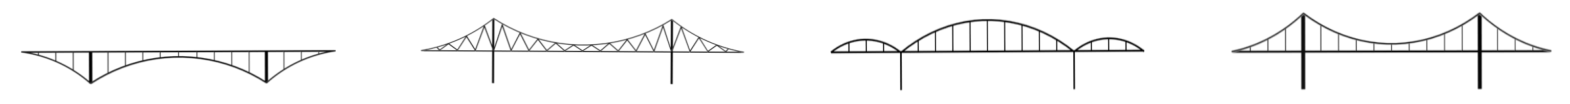

In [4]:
train_sample = sample_batch(train_data)
print(train_sample.shape) 
np.savetxt('train_sample[0]-1.txt', train_sample[0][:,:,0])  #像素值0~255
display(train_sample, n=4)

In [5]:
# Preprocess the data
def preprocess(img):
    img = (tf.cast(img, "float32") / 255.0) #tf.cast()函数：数据类型转换。这里将0~255转换为0~1
    img = img + tf.random.normal((BATCH_SIZE,IMAGE_SIZE[0],IMAGE_SIZE[1],1),mean=0.0,stddev=0.01) #“图像数据增强之添加噪声.mhtml”。噪音有意义的，取消后效果变差。《python深度学习》P111数据增强技术
    #img =tf.clip_by_value(img,0,1) #剪裁效果差
    return img

train_dataset = train_data.map(lambda x: preprocess(x))

(32, 128, 512, 1)


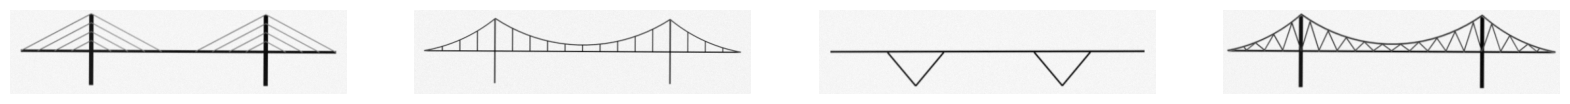

In [6]:
train_sample = sample_batch(train_dataset)
print(train_sample.shape) 
np.savetxt('train_sample[0]-2.txt', train_sample[0][:,:,0])  #像素值0~1
display(train_sample, n=4)

In [7]:
#来自https://tensorflow.google.cn/probability/api_docs/python/tfp/bijectors/GlowDefaultNetwork的“View source on GitHub”
class GlowDefaultNetwork(tfk.Sequential):
  """Default network for the glow bijector.

  This builds a 3 layer convolutional network, with relu activation functions
  and he_normal initializer. The first and third layers have default kernel
  shape of 3, and the second layer is a 1x1 convolution. This is the setup
  in the public version of Glow.

  The output of the convolutional network defines the components of an Affine
  transformation (i.e. y = m * x + b), where m, x, and b are all tensors of
  the same shape, and * indicates elementwise multiplication.
  """

  def __init__(self, input_shape, num_hidden=num_hidden, kernel_shape=3): #2024.01.07唯一修改之处：num_hidden=400改为num_hidden=num_hidden
    """Default network for glow bijector."""
    # Default is scale and shift, so 2c outputs.
    this_nchan = input_shape[-1] * 2
    conv_last = functools.partial(
        tfkl.Conv2D,
        padding='same',
        kernel_initializer=tf.initializers.zeros(),
        bias_initializer=tf.initializers.zeros())
    super(GlowDefaultNetwork, self).__init__([
        tfkl.Input(shape=input_shape),
        tfkl.Conv2D(num_hidden, kernel_shape, padding='same',
                    kernel_initializer=tf.initializers.he_normal(),
                    activation='relu'),
        tfkl.Conv2D(num_hidden, 1, padding='same',
                    kernel_initializer=tf.initializers.he_normal(),
                    activation='relu'),
        conv_last(this_nchan, kernel_shape)
    ])


In [8]:
output_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],1)
#来自https://tensorflow.google.cn/probability/api_docs/python/tfp/distributions/TransformedDistribution
flow = tfd.TransformedDistribution(
    distribution=   tfd.MultivariateNormalDiag( tf.zeros(
                                                (tf.math.reduce_prod(output_shape), )
                                                ),
                                             tf.ones(
                                                (tf.math.reduce_prod(output_shape), )
                                                )
                                           ),
    bijector    =   tfb.Glow(output_shape=output_shape,
                             num_glow_blocks = num_glow_blocks, 
                             num_steps_per_block=num_steps_per_block, 
                             coupling_bijector_fn=GlowDefaultNetwork, #自定义
                             exit_bijector_fn=tfb.GlowDefaultExitNetwork,
                            ),
                            )

In [10]:
class flowKerasModel(tf.keras.Model):
    def __init__(self,flow):
        super().__init__()
        self.flow = flow
      
    @tf.function
    def call(self, inputs):
        pass

my_flow = flowKerasModel(flow) #仅用于输出模型参数、保存权重，不可以用于训练（因为出错AttributeError: 'float' object has no attribute 'items'）
my_flow(tf.random.normal((1,tf.math.reduce_prod(output_shape))))
my_flow.summary()

Model: "flow_keras_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 5,184,892
Trainable params: 5,183,860
Non-trainable params: 1,032
_________________________________________________________________


In [11]:
#因为没搞定keras函数式API、模型子类化，故只能采用tf原生代码
checkpoint = tf.train.Checkpoint(my_flow=my_flow) #用于保存多个权重参数文件。 tf.train.Checkpoint 支持图执行模式。
def fit(train_dataset,epochs):
    for epoch_counter in range(epochs):
        print("Epoch=%s"%(epoch_counter))
        for batch in train_dataset: #并行计算时不插入任何代码
            loss = train_step(batch)
            #print("loss: %0.0f " % loss.numpy())#临时测试用，正式训练时取消
        save_samples('epoch%s'%(epoch_counter)) 
        checkpoint.save('./models/') #保存多个权重参数文件的目录.而my_flow.save_weights('./models/')无法保存多个文件。h5格式权重参数保存失败，生成图片是随机点。
        #这里把并行计算train_step(batch)、save_samples('epoch%s'%(epoch_counter)) 、checkpoint.save('./models/')的代码归在一起，感觉合理。
        loss_history.append(loss.numpy()) 
        print("loss: %0.0f " % loss.numpy())
    return None

@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(flow.log_prob(batch))
    gradients = tape.gradient(loss,flow.trainable_variables)
    optimizer.apply_gradients(zip(gradients,flow.trainable_variables))
    return loss

def save_samples(file_name):
    images = sample(num_rows_samples*num_columns_samples)
    fig = plt.figure(figsize=figsize)
    for i in range(num_rows_samples*num_columns_samples):
        plt.subplot(num_rows_samples,num_columns_samples,i+1)
        plt.imshow(images[i], cmap = 'gray') #'gray_r'黑白反相
        plt.axis('off')
    plt.savefig('./images/%s.png'%(file_name))
    plt.close(fig)

@tf.function
def sample(N):
    return flow.sample(N)

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                     clipnorm=1. #效果提示了一点。所有参数梯度将被裁剪，让其 l2 范数最大为 1：g * 1 / max(1, l2_norm)。clipnorm、clipvalue两者取一。
                                     #clipvalue=0.5 #没什么效果。所有参数梯度将被裁剪到数值范围内： 最大值 0.5， 最小值 -0.5。clipnorm、clipvalue两者取一。
                                    ) 
loss_history = []
fit(train_dataset,epochs)

endTime=time.time()
print('How many minutes:',(endTime-startTime)/60)

Epoch=0
loss: -200299 
Epoch=1
loss: -201760 
Epoch=2
loss: -202486 
Epoch=3
loss: -203012 
Epoch=4



KeyboardInterrupt



In [ ]:
print(len(loss_history)) 
with open('history.history.txt', 'w') as file_object:
    file_object.write(str(loss_history))  #损失写入文件

epochs = range(1, len(loss_history) + 1)
plt.plot(epochs, loss_history, 'b', label='loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./images/loss_history.png')